# Mid-Sagittal plane algorithm

### Import relevant packages

In [99]:
import os
import time
import gzip

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import imageio

import nibabel as nib
from nibabel.orientations import aff2axcodes

import joblib

from scipy.ndimage import center_of_mass, find_objects
from scipy.optimize import minimize
from scipy.interpolate import RegularGridInterpolator
from scipy.stats import norm

import ipywidgets as widgets
from matplotlib.lines import Line2D
from matplotlib.backends.backend_agg import FigureCanvasAgg as FigureCanvas

In [100]:
def load_nifti_file(file_path):
    """
    Load a NIfTI file and return its data and voxel size, reoriented to (coronal, sagittal, axial).

    Parameters
    ----------
    file_path : str
        Path to the NIfTI file.

    Returns
    -------
    tuple
        data : np.ndarray
            The image data array, reoriented to (coronal, sagittal, axial).
        voxel_size : np.ndarray
            The voxel size for each axis, reordered to match the data orientation.
    """
    nifti_img = nib.load(file_path)
    data = nifti_img.get_fdata()
    voxel_size = np.array(nifti_img.header.get_zooms())

    # determine which data-axis is world-X, world-Y, world-Z
    codes = aff2axcodes(nifti_img.affine)  
    code2world = {'L':0,'R':0,'P':1,'A':1,'I':2,'S':2}
    world_of_axis = [code2world[c] for c in codes]  
    # find data-axis indices for each world axis
    idx_x = world_of_axis.index(0)  # sagittal
    idx_y = world_of_axis.index(1)  # coronal
    idx_z = world_of_axis.index(2)  # axial

    # we want new_data[ coronal, sagittal, axial ]
    new_order = [idx_y, idx_x, idx_z]
    data = np.transpose(data, new_order)
    voxel_size = np.array(tuple(voxel_size[new_order]))

    return data, voxel_size

def open_gzip_file(gzip_file_path):
    """
    Open a gzip-compressed file and return its content as bytes.

    Parameters
    ----------
    gzip_file_path : str
        The path to the gzip file.

    Returns
    -------
    bytes or None
        The content of the gzip file, or None if an error occurs.
    """
    try:
        with gzip.open(gzip_file_path, 'rb') as f_in:
            file_content = f_in.read()
        return file_content
    except Exception as e:
        print(f'Error opening {gzip_file_path}: {e}')
        return None

def get_image_and_voxel_size_from_gzip(gzip_file_path):
    """
    Extract the image array and voxel size from a gzipped NIfTI file.

    Parameters
    ----------
    gzip_file_path : str
        Path to the gzipped NIfTI file.

    Returns
    -------
    tuple
        img_data : np.ndarray or None
            The image data array, or None if loading fails.
        voxel_size : np.ndarray or None
            The voxel size for each axis, or None if loading fails.
    """
    file_content = open_gzip_file(gzip_file_path)
    if file_content is not None:
        with open('temp_nifti.nii', 'wb') as temp_file:
            temp_file.write(file_content)

        # 🔹 Debugging: Check if the file was actually written
        file_size = os.path.getsize('temp_nifti.nii')
        if file_size == 0:
            print(f"❌ Error: 'temp_nifti.nii' was written but is empty! ({gzip_file_path})")
            return None, None

        img_data, voxel_size = load_nifti_file('temp_nifti.nii')
        os.remove('temp_nifti.nii')  # Remove temp file after reading
        
        return img_data, voxel_size
    else:
        print(f"❌ Error: Failed to read file content from '{gzip_file_path}'")
        return None, None

def load_patient_structures(patient_folder: str, structure_names=None):
    """
    Load specified structures from a patient folder containing NIfTI or gzipped NIfTI files.

    Parameters
    ----------
    patient_folder : str
        Path to the folder containing patient structure files.
    structure_names : list of str, optional
        List of structure names to load (default: ['Image']).

    Returns
    -------
    dict
        Dictionary mapping structure names to (image, voxel_size) tuples.
    """
    if structure_names is None:
        structure_names = ['Image']

    struct_dict = {}
    for root, _, files in os.walk(patient_folder):
        for f in files:
            # Only NIfTI files
            if not (f.endswith('.nii.gz') or f.endswith('.nii')):
                continue

            name_part = f
            
            # Remove extension
            if name_part.endswith('.nii.gz'):
                base = name_part[:-7]
            else:
                base = name_part[:-4]

            # Compare with expected structure names (case-insensitive)
            for struct_name in structure_names:
                if base.lower() == struct_name.lower():
                    file_path = os.path.join(root, f)
                    try:
                        if f.endswith('.nii.gz'):
                            img, voxel_size = get_image_and_voxel_size_from_gzip(file_path)
                        else:
                            img, voxel_size = load_nifti_file(file_path)
                    except Exception as e:
                        logging.error(f"Error loading '{struct_name}' from {file_path}: {e}")
                        continue

                    if img is not None:
                        struct_dict[struct_name] = (img, voxel_size)
                        print(f"Loaded '{struct_name}' from {file_path}")
                    break
    return struct_dict

### Image Processing

In [101]:
def mask_via_threshold(ct_image, HU_range=(300, 1500)):
    """
    Create a binary mask for the CT image using a specified Hounsfield Unit (HU) range.

    Parameters
    ----------
    ct_image : np.ndarray
        The CT image array.
    HU_range : tuple of (int, int)
        Lower and upper HU bounds for thresholding.

    Returns
    -------
    np.ndarray
        Binary mask where voxels within the HU range are set to 1.
    """
    bone_mask = np.zeros_like(ct_image)
    lower_bound, upper_bound = HU_range
    bone_mask[(ct_image >= lower_bound) & (ct_image <= upper_bound)] = 1

    return bone_mask

def crop_patient_volumes(struct_dict, slice_axis=2, slice_range=None):
    """
    Crop all structures in the patient dictionary along a specified axis and range.

    Parameters
    ----------
    struct_dict : dict
        Dictionary of structures, each as (image, voxel_size) or image array.
    slice_axis : int
        Axis along which to crop (default: 2, axial).
    slice_range : tuple or None
        (start, end) indices for cropping. If None, uses GTVp mask or full range.

    Returns
    -------
    dict
        Dictionary with cropped structure arrays.
    """
    image = struct_dict['Image'][0]
    if 'GTVp' in struct_dict:
        gtvp = struct_dict['GTVp'][0]
        slc = find_objects(gtvp.astype(bool))[0]
        start, end = slc[slice_axis].start, slc[slice_axis].stop - 1
    elif slice_range is not None:
        start, end = slice_range
    else:
        start, end = 0, image.shape[slice_axis] - 1

    idx = np.arange(start, end + 1)

    def _crop(arr, idx):
        return np.take(arr, idx, axis=slice_axis)

    for structure in struct_dict:
        struct_dict[structure] = _crop(struct_dict[structure][0], idx)

    idx_interpolation = np.arange(start - 5, end + 1 + 5)
    interpolation_image = _crop(image, idx_interpolation)
    
    return struct_dict, interpolation_image 

def preprocess_bone_image(struct_dict, HU_range):
    """
    Preprocess the CT image to extract bone regions using a HU threshold and optional body mask.

    Parameters
    ----------
    struct_dict : dict
        Dictionary of structures, must include 'Image' and optionally 'Body'.
    HU_range : tuple of (int, int)
        Lower and upper HU bounds for bone thresholding.

    Returns
    -------
    tuple
        proc_image : np.ndarray
            The processed CT image (optionally masked by 'Body').
        bone_ct : np.ndarray
            The CT image with only bone voxels retained.
    """
    proc_image = struct_dict['Image'].astype(np.int16)

    if 'Body' in struct_dict:
        body = struct_dict['Body']
        proc_image = np.where(body == 1, proc_image, np.min(proc_image))

    bone_mask = mask_via_threshold(proc_image, HU_range).astype(np.uint16)
    bone_ct = proc_image * bone_mask

    return proc_image, bone_ct

### Parametrization

In [102]:
def vector_to_angles(vector):
    """
    Convert a 3D vector to spherical coordinates (azimuthal, polar, radius).

    Parameters
    ----------
    vector : array-like of shape (3,)
        The (x, y, z) vector.

    Returns
    -------
    np.ndarray
        Array of [azimuthal, polar, R] in radians and length.
    """
    x, y, z = vector

    # Calculate the distance from the origin
    R = np.linalg.norm(vector)

    # Calculate the distance from the origin in xy plane
    r = np.sqrt(x**2 + y**2)

    # Calculate the angle in the xy plane with respect to the x-axis
    azimuthal = np.arctan2(y, x)

    # Calculate the angle in the xz plane with respect to the z-axis
    polar = np.arctan2(r, z)

    return np.array([azimuthal, polar, R])

def angles_to_vector(azimuthal, polar, R):
    """
    Convert spherical coordinates (azimuthal, polar, radius) to a 3D vector.

    Parameters
    ----------
    azimuthal : float
        Azimuthal angle in radians.
    polar : float
        Polar angle in radians.
    R : float
        Radius (length).

    Returns
    -------
    np.ndarray
        The (x, y, z) vector.
    """
    x = R * np.sin(polar) * np.cos(azimuthal)
    y = R * np.sin(polar) * np.sin(azimuthal)
    z = R * np.cos(polar)
    
    return np.array([x, y, z])

def generate_normal(theta: float, phi: float) -> np.ndarray:
    """
    Generate a 3D normal vector from spherical angles theta and phi.

    Parameters
    ----------
    theta : float or np.ndarray
        Azimuthal angle(s) in radians.
    phi : float or np.ndarray
        Polar angle(s) in radians.

    Returns
    -------
    np.ndarray
        The normal vector(s) as (x, y, z).
    """
    # When theta and phi are arrays, we need to stack along the last axis
    x = np.sin(phi) * np.cos(theta)
    y = np.sin(phi) * np.sin(theta)
    z = np.cos(phi)
    
    # Stack components along the last axis to get shape (..., 3)
    return np.stack([x, y, z], axis=-1)

### Interpolation

In [103]:
def get_cached_interpolator(output_dir, image, voxel_size,
                            filename='interpolator.joblib',
                            method='cubic',
                            pad_slices=5):
    """
    Load or build and cache a RegularGridInterpolator for a cropped+Padded volume,
    shifting the z‐coordinates so that z=0 aligns with the first slice of the original crop.

    Parameters
    ----------
    output_dir : str
        Directory to look for/save the cached interpolator.
    image : np.ndarray
        Cropped+Padded image of shape (Ny, Nx, Nz_pad).
    voxel_size : sequence of 3 floats
        Physical spacing in mm along (Y, X, Z) axes.
    filename : str, optional
        Name of the .joblib file to load/save under output_dir.
    method : str, optional
        Interpolation method: 'cubic', 'linear', etc.
    pad_slices : int, optional
        Number of padded slices at the beginning of the volume. These
        will be assigned negative z-coordinates.

    Returns
    -------
    RegularGridInterpolator
        Interpolator mapping (y_mm, x_mm, z_mm_shifted) to intensity,
        where z_mm_shifted = 0 at the first slice *after* the pad.
    """
    os.makedirs(output_dir, exist_ok=True)
    interpolator_path = os.path.join(output_dir, filename)

    Ny, Nx, Nz_pad = image.shape
    dy, dx, dz = voxel_size

    # build physical‐space sample grids
    grid_y = np.arange(Ny) * dy
    grid_x = np.arange(Nx) * dx
    # shift z so that first un‐padded slice is at z=0
    grid_z = (np.arange(Nz_pad) - pad_slices) * dz

    if os.path.exists(interpolator_path):
        interpolator = joblib.load(interpolator_path)
    else:
        start = time.time()
        interpolator = RegularGridInterpolator(
            (grid_y, grid_x, grid_z),
            image,
            method=method,
            bounds_error=False,
            fill_value=None
        )
        elapsed = time.time() - start
        print(f"Interpolator built in {elapsed:.2f}s; cached to {interpolator_path}")
        joblib.dump(interpolator, interpolator_path)

    return interpolator


### Objective Function

In [104]:
def compute_signed_distances(params_array, image, voxel_size):
    """
    Compute signed distances from all nonzero voxels in the image to a plane.

    Parameters
    ----------
    params_array : array-like of shape (3,)
        Plane parameters [azimuthal, polar, L].
    image : np.ndarray
        Binary or intensity image.
    voxel_size : array-like of shape (3,)
        Physical voxel size for each axis.

    Returns
    -------
    tuple
        d : np.ndarray
            Signed distances from each voxel to the plane.
        n : np.ndarray
            Normal vector of the plane.
        indices_coord_syst_phy : np.ndarray
            Physical coordinates of the voxels in the coordinate system.
        indices_image : np.ndarray
            Indices of nonzero voxels in the image.
    """
    azimuthal, polar, L = params_array

    indices_image = np.array(np.nonzero(image)).T

    indices_image_phy = indices_image * voxel_size

    indices_coord_syst_phy = np.stack([
        indices_image_phy[:,1],
        indices_image_phy[:,0],
        indices_image_phy[:,2]
    ], axis=1)

    n = generate_normal(azimuthal, polar)

    d = indices_coord_syst_phy.dot(n) - L

    return d, n, indices_coord_syst_phy, indices_image

def quadratic_loss_function(diff):
    """
    Compute the quadratic loss for an array of differences.

    Parameters
    ----------
    diff : np.ndarray
        Array of differences.

    Returns
    -------
    np.ndarray
        Quadratic loss values for each element in diff.
    """
    return 0.5 * diff**2

def huber_loss_function(diff, delta=300):
    """
    Compute the Huber loss for an array of differences.

    Parameters
    ----------
    diff : np.ndarray
        Array of differences.
    delta : float, optional
        Huber loss delta parameter.

    Returns
    -------
    np.ndarray
        Huber loss values for each element in diff.
    """
    h_loss = np.where(np.abs(diff) <= delta, 0.5 * diff**2,
                    delta * (np.abs(diff) - 0.5 * delta))
    return h_loss

def p_huber_loss(r, c=300.0, p=1.4):
    """Generalised Huber with polynomial tail."""
    a = np.abs(r)
    quad_mask = a <= c
    loss = np.empty_like(r, dtype=float)

    # quadratic core
    loss[quad_mask] = 0.5 * r[quad_mask] ** 2

    # tail: (2 c^{2-p} / (2-p)) |r|^p  - c^2 / (2-p)
    coeff = 2 * c ** (2 - p) / (2 - p)
    tail = coeff * (a[~quad_mask] ** p) - c ** 2 / (2 - p)
    loss[~quad_mask] = tail
    return loss


def welsch_loss(r, c=200):
    """ρc(r) for Welsch."""
    factor = (r / c) ** 2
    return 0.5 * c ** 2 * (1.0 - np.exp(-factor))

def piecewise_loss(r):
    """
    Custom piecewise loss function:
    - Quadratic for |r| <= 200
    - Linear for 200 < |r| < 1500
    - Quadratic for |r| >= 1500
    Supports scalar or NumPy array input.
    
    Parameters
    ----------
    r : float or np.ndarray
        Residual value(s)
    
    Returns
    -------
    loss : float or np.ndarray
        Computed loss value(s)
    """
    r = np.asarray(r)
    abs_r = np.abs(r)
    
    loss = np.where(
        abs_r <= 200,
        r**2,
        np.where(
            abs_r < 1500,
            1700 * abs_r - 300_000,
            r**2
        )
    )
    
    return loss



def piecewise_intensity_loss(I_orig, I_m, threshold=2800):
    """
    Compute a continuous piecewise loss between original and mirrored intensities.

    For each voxel:
      - If I_m < threshold, loss = 0.5 * (I_orig - I_m)^2
      - Else, loss = 0.1 * (I_orig - I_m) + offset, chosen so that loss is continuous at I_m = threshold.

    Parameters
    ----------
    I_orig : array-like
        Original intensities.
    I_m : array-like
        Mirrored/interpolated intensities.
    threshold : float, optional
        Intensity threshold for switching between squared and linear loss.

    Returns
    -------
    loss : np.ndarray
        Array of the same shape as inputs, containing the piecewise continuous loss.
    """
    I_orig = np.asarray(I_orig)
    I_m = np.asarray(I_m)
    diff = I_orig - I_m

    # Compute diff at the threshold boundary for each voxel
    diff_thresh = I_orig - threshold

    # Squared part below threshold
    loss_sq = 0.5 * diff**2

    # Linear part above threshold, with offset for continuity
    a = 0.1
    offset = 0.5 * diff_thresh**2 - a * diff_thresh
    loss_lin = a * diff + offset

    # Combine piecewise
    loss = np.where(I_m < threshold, loss_sq, loss_lin)
    return loss



def compute_objective(params_array, bone, interpolator_intensity, voxel_size, delta):
    """
    Compute the objective function value for plane symmetry optimization.

    Parameters
    ----------
    params_array : array-like of shape (3,)
        Plane parameters [azimuthal, polar, L].
    bone : np.ndarray
        Bone mask or intensity image.
    interpolator_intensity : RegularGridInterpolator
        Interpolator for the original image.
    voxel_size : array-like of shape (3,)
        Physical voxel size for each axis.
    delta : float
        Huber loss delta parameter.

    Returns
    -------
    float
        The mean Huber loss for the current plane parameters.
    """
    d, n, indices_coord_syst_phy, indices_image = compute_signed_distances(params_array, bone, voxel_size)
    x_m_coord_syst_phy = indices_coord_syst_phy - 2 * d[:, None] * n[None, :]
    x_m_image_phy = np.array([x_m_coord_syst_phy[:, 1], x_m_coord_syst_phy[:, 0], x_m_coord_syst_phy[:, 2]]).T
    I_m = interpolator_intensity(x_m_image_phy)
    I_orig = bone[indices_image[:, 0], indices_image[:, 1], indices_image[:, 2]]
    diff = I_orig - I_m
    #f = np.sum(piecewise_intensity_loss(I_orig, I_m)).mean()
    #f_1= np.sum(quadratic_loss_function(diff)).mean()

    f = np.sum(huber_loss_function(diff, delta=delta)).mean()
    #f = np.sum(welsch_loss(diff, c=delta)).mean()  # Using Welsch loss instead of Huber
    #f = np.sum(p_huber_loss(diff, c=delta, p=1)).mean()  # Using generalized Huber loss
    #f = np.sum(piecewise_loss(diff)).mean()  # Using custom piecewise loss
    return f



def compute_objective_initialization(params_array, bone, interpolator_intensity, voxel_size):
    """
    Compute the objective function value for plane symmetry optimization.

    Parameters
    ----------
    params_array : array-like of shape (3,)
        Plane parameters [azimuthal, polar, L].
    bone : np.ndarray
        Bone mask or intensity image.
    interpolator_intensity : RegularGridInterpolator
        Interpolator for the original image.
    voxel_size : array-like of shape (3,)
        Physical voxel size for each axis.
    delta : float
        Huber loss delta parameter.

    Returns
    -------
    float
        The mean Huber loss for the current plane parameters.
    """
    d, n, indices_coord_syst_phy, indices_image = compute_signed_distances(params_array, bone, voxel_size)
    x_m_coord_syst_phy = indices_coord_syst_phy - 2 * d[:, None] * n[None, :]
    x_m_image_phy = np.array([x_m_coord_syst_phy[:, 1], x_m_coord_syst_phy[:, 0], x_m_coord_syst_phy[:, 2]]).T
    I_m = interpolator_intensity(x_m_image_phy)
    I_orig = bone[indices_image[:, 0], indices_image[:, 1], indices_image[:, 2]]
    diff = I_orig - I_m

    mad = np.median(np.abs(diff - np.median(diff)))
    sigma_hat = 1.4826 * mad
    delta = 1.345 * sigma_hat
    
    f = np.sum(quadratic_loss_function(diff)).mean()
    

    # plt.figure(figsize=(7, 4))
    # n, bins, patches = plt.hist(diff, bins=50, density=True, alpha=0.6, color='g', label='Residuals')

    # # Fit and plot normal distribution
    # mu, std = np.mean(diff), np.std(diff)
    # xmin, xmax = plt.xlim()
    # x = np.linspace(xmin, xmax, 100)
    # p = norm.pdf(x, mu, std)
    # plt.plot(x, p, 'k', linewidth=2, label='Normal fit')

    # # Plot delta_1 as a vertical line
    # plt.axvline(delta_1, color='r', linestyle='--', label=f'delta_1 = {delta_1:.2f}')
    # plt.axvline(-delta_1, color='r', linestyle='--')

    # plt.title(f'delta_1 = {delta_1:.2f}, f_1 = {f_1:.2f}')
    # plt.xlabel('Residual (diff)')
    # plt.ylabel('Density')
    # plt.legend()
    # plt.tight_layout()
    # plt.show()


    return f, delta

### Parameter Initialization

In [105]:
def parameter_initialization(
    image,
    bone,
    output_path,
    interpolator_intensity,
    voxel_size,
    azimuthal_deg_range=(0, 90),
    polar_deg_range=(90, 10),
    initialization_steps=10
):
    """
    Perform grid search initialization for plane parameters by evaluating the objective
    function over a range of azimuthal and polar angles.

    Returns the best plane parameters [azimuthal, polar, L].
    """
    start = time.time()

    # 1) Compute center of mass in physical space (air < -900 HU set to zero)
    image_com = image.copy()
    image_com[image_com < -900] = 0
    com_vox = center_of_mass(image_com)      # in voxel indices (z, y, x)
    com_phy = np.array([com_vox[1], com_vox[0], com_vox[2]]) * voxel_size

    # 2) Build angular search ranges (in radians)
    az_cent_deg, az_half_deg = azimuthal_deg_range
    pol_cent_deg, pol_half_deg = polar_deg_range
    az_cent_rad, az_half_rad = np.deg2rad([az_cent_deg, az_half_deg])
    pol_cent_rad, pol_half_rad = np.deg2rad([pol_cent_deg, pol_half_deg])

    azimuthal_angles = np.linspace(
        az_cent_rad - az_half_rad,
        az_cent_rad + az_half_rad,
        initialization_steps
    )
    polar_angles = np.linspace(
        pol_cent_rad - pol_half_rad,
        pol_cent_rad + pol_half_rad,
        initialization_steps
    )

    os.makedirs(output_path, exist_ok=True)
    mse_file = os.path.join(output_path, "Initialization_obj_fun.npy")
    params_file = os.path.join(output_path, "Initialization_plane_params.npy")
    delta_file = os.path.join(output_path, "Initialization_delta.npy")

    # 3) If not already computed, run grid search
    if not (os.path.exists(mse_file) and os.path.exists(params_file)):
        print("Starting parameter initialization...")

        # Create grid of angles
        theta_grid, phi_grid = np.meshgrid(
            azimuthal_angles,
            polar_angles,
            indexing="ij"
        )  # both shape (N, N)

        # Compute normals for each (θ, φ)
        n = generate_normal(theta_grid, phi_grid)  # shape (N, N, 3)

        # Compute offsets L_{ij} = n_{ij} · com_phy
        L_grid = np.tensordot(n, com_phy, axes=([-1], [0]))  # shape (N, N)

        # Flatten into list of plane parameters
        planes = np.stack([
            theta_grid.ravel(),
            phi_grid.ravel(),
            L_grid.ravel()
        ], axis=1)  # shape (N*N, 3)

        # Evaluate objective for each plane: returns list of (f, δ)
        results = [
            compute_objective_initialization(p, bone, interpolator_intensity, voxel_size)
            for p in planes
        ]
        mse_vals, delta_vals = zip(*results)
        mse_array = np.array(mse_vals)        # shape (N*N,)
        delta_array = np.array(delta_vals)    # shape (N*N,)

        # Find best index
        best_idx = np.argmin(mse_array)
        best_f = mse_array[best_idx]
        best_delta = delta_array[best_idx]
        print(f"Minimum objective f = {best_f:.4f} at index {best_idx}")
        print(f"Corresponding δ = {best_delta:.4f}")

        # Save for reuse
        np.save(mse_file, mse_array)
        np.save(params_file, planes)
        np.save(delta_file, delta_array)

        end = time.time()
        print(f"Time taken for initialization: {end - start:.2f} s")

    else:
        mse_array = np.load(mse_file)     # shape (N*N,)
        planes = np.load(params_file)     # shape (N*N, 3)
        delta_array = np.load(delta_file)  # shape (N*N,)
        N = initialization_steps
        theta_grid = np.linspace(
            az_cent_rad - az_half_rad,
            az_cent_rad + az_half_rad,
            N
        )
        phi_grid = np.linspace(
            pol_cent_rad - pol_half_rad,
            pol_cent_rad + pol_half_rad,
            N
        )

    # 4) Select best parameters from saved results
    best_idx = np.argmin(mse_array)
    best_params = planes[best_idx]  # [azimuthal, polar, L]
    best_delta = delta_array[best_idx]

    # 5) Optional: plot heatmap of MSE over (θ, φ)
    mse_grid = mse_array.reshape(initialization_steps, initialization_steps)
    plot_mse_heatmap(
        azimuthal_angles,
        polar_angles,
        mse_grid,
        title=(
            f"MSE Heatmap (θ, φ) – optimum at:\n"
            f"θ={np.rad2deg(best_params[0]):.2f}°, "
            f"φ={np.rad2deg(best_params[1]):.2f}°, "
            f"L={best_params[2]:.2f}\n"
            f"MSE={mse_grid.flat[best_idx]:.2f}"
        ),
        output_path=output_path
    )
    return best_params, best_delta

In [106]:
def plot_mse_heatmap(azimuthal_angles, polar_angles, mse_array, title="MSE Heatmap", output_path=None):
    """
    Plot and optionally save a heatmap of the objective function values over a grid of angles.

    Parameters
    ----------
    azimuthal_angles : np.ndarray
        Array of azimuthal angles (radians).
    polar_angles : np.ndarray
        Array of polar angles (radians).
    mse_array : np.ndarray
        Array of objective function values.
    title : str, optional
        Title for the plot.
    output_path : str or None
        Directory to save the heatmap image, if provided.
    """
    P = len(polar_angles)
    T = len(azimuthal_angles)

    mse_2d = mse_array.reshape(P, T)

    theta_deg = np.rad2deg(azimuthal_angles)
    phi_deg   = np.rad2deg(polar_angles)

    TH, PH = np.meshgrid(theta_deg, phi_deg)
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(TH, PH, mse_2d, shading='auto', cmap='viridis', vmin = np.min(mse_2d) , vmax = np.min(mse_2d) + 100000)
    plt.colorbar(label='MSE')
    plt.xlabel('Azimuthal angle θ (°)')
    plt.ylabel('Polar angle φ (°)')
    plt.title(title)
    plt.grid(visible=True, linestyle='--', alpha=0.7)
    if output_path is not None:
        plt.savefig(os.path.join(output_path, "mse_heatmap.png"), dpi=300)

### Optimization

In [107]:
def optimize_plane(initial_params_array, image, interpolator_intensity, voxel_size, delta):
    """
    Optimize the plane parameters to minimize the objective function using BFGS.

    Parameters
    ----------
    initial_params_array : array-like of shape (3,)
        Initial guess for plane parameters [azimuthal, polar, L].
    image : np.ndarray
        The image or mask to optimize over.
    interpolator_intensity : RegularGridInterpolator
        Interpolator for the original image.
    voxel_size : array-like of shape (3,)
        Physical voxel size for each axis.
    delta : float
        Huber loss delta parameter.

    Returns
    -------
    OptimizeResult
        Result object from scipy.optimize.minimize, with additional attributes:
        - objective_value_list: list of objective values per iteration.
        - params_list: list of parameter arrays per iteration.
    """
    objective_value_list = []
    params_list = []

    def callback(xk):
        f_val = compute_objective(xk, image, interpolator_intensity, voxel_size, delta)
        objective_value_list.append(f_val)
        params_list.append(xk.copy())

    res = minimize(compute_objective, x0=initial_params_array, args=(image, interpolator_intensity, voxel_size, delta),
                   method='BFGS', jac=None, callback=callback)
    params_list.append(res.x.copy())
    objective_value_list.append(res.fun)

    res.objective_value_list = objective_value_list
    res.params_list = params_list

    return res

def run_or_load_optimization(output_path_patient,
                             image,
                             voxel_size_image,
                             delta,
                             initial_plane,
                             bone_ct,
                             interpolator,
                             optimized_parameter_list,
                             optimized_objective_value_list):
    """
    Run or load the optimization of plane parameters for a single patient.

    Parameters
    ----------
    output_path_patient : str
        Directory to save/load optimization results.
    image : np.ndarray
        The original image array.
    voxel_size_image : array-like of shape (3,)
        Physical voxel size for each axis.
    delta : float
        Huber loss delta parameter.
    initial_plane : array-like of shape (3,)
        Initial guess for plane parameters.
    bone_ct : np.ndarray
        Bone mask or intensity image.
    interpolator : RegularGridInterpolator
        Interpolator for the original image.
    optimized_parameter_list : list
        List to append optimized parameters to.
    optimized_objective_value_list : list
        List to append optimized objective values to.

    Returns
    -------
    tuple
        optimized_parameters : np.ndarray
            Optimized plane parameters [azimuthal, polar, L].
        optimized_objective_value : float
            Final objective function value.
    """
    param_path = os.path.join(output_path_patient, "parameter_array.npy")
    obj_path   = os.path.join(output_path_patient, "objective_value_array.npy")

    if os.path.exists(param_path) and os.path.exists(obj_path):
        # load the last saved result
        params_arr = np.load(param_path)
        obj_arr    = np.load(obj_path)
        optimized_parameters      = params_arr[-1]
        optimized_objective_value = obj_arr[-1]
        print(f"Optimized parameters: "
              f"{np.rad2deg(optimized_parameters[0]):.2f}°, "
              f"{np.rad2deg(optimized_parameters[1]):.2f}°, "
              f"{optimized_parameters[2]:.2f} mm "
              f"with MSE {optimized_objective_value:.2f}")
        
        make_plane_gif(image, voxel_size_image, params_arr, obj_arr, output_path_patient)
    else:
        start = time.time()
        res = optimize_plane(initial_plane,
                             bone_ct,
                             interpolator,
                             voxel_size_image,
                             delta)
        end = time.time()
        print(f"Optimization took {end - start:.2f} seconds.")

        optimized_parameters      = res.x
        optimized_objective_value = res.fun
        print(f"Optimized parameters: "
              f"{np.rad2deg(optimized_parameters[0]):.2f}°, "
              f"{np.rad2deg(optimized_parameters[1]):.2f}°, "
              f"{optimized_parameters[2]:.2f} mm "
              f"with MSE {optimized_objective_value:.2f}")
        
        make_plane_gif(image, voxel_size_image, np.array(res.params_list), np.array(res.objective_value_list), output_path_patient)
        np.save(param_path,   np.array(res.params_list))
        np.save(obj_path,     np.array(res.objective_value_list))

        optimized_parameter_list.append(optimized_parameters)
        optimized_objective_value_list.append(optimized_objective_value)

    return optimized_parameters, optimized_objective_value

### Verification Plots

In [108]:
def make_plane_gif(image_3d, voxel_size, plane_params, objective_values, output_path, duration=2):
    """
    Create a GIF showing the evolution of plane contours on the middle slice of a 3D image.

    Parameters
    ----------
    image_3d : np.ndarray
        The 3D image array (coronal, sagittal, axial).
    voxel_size : tuple of float
        Spacing in mm along (coronal=y, sagittal=x, axial=z).
    plane_params : np.ndarray
        Array of plane parameters for each frame (N, 3).
    objective_values : np.ndarray
        Array of objective values for each frame (N,).
    output_path : str
        Directory to save the resulting GIF.
    duration : float, optional
        Time in seconds each frame is shown.
    """
    H, W, D = image_3d.shape
    sy, sx, sz = voxel_size

    # middle slice and its physical z
    z0 = D // 2
    z0_mm = z0 * sz
    slice_img = image_3d[:, :, z0]

    # physical grid for contour
    y_mm = np.arange(H) * sy
    x_mm = np.arange(W) * sx
    X_mm, Y_mm = np.meshgrid(x_mm, y_mm)  # note: meshgrid(x,y) -> X shape (len(y), len(x))

    writer = imageio.get_writer(os.path.join(output_path, "plane_optimization.gif"), mode='I', duration=duration)

    for idx in range(plane_params.shape[0]):
        # extract parameters
        theta, phi, L_mm = plane_params[idx]
        objective_value = objective_values[idx]
        # compute plane normal
        n = np.array([
            np.sin(phi) * np.cos(theta),
            np.sin(phi) * np.sin(theta),
            np.cos(phi)
        ])
        nx, ny, nz = n

        # plane constant
        C = L_mm - nz * z0_mm

        # contour function in mm
        F = nx * X_mm + ny * Y_mm - C

        # plot
        fig = plt.figure(figsize=(6,6))
        canvas = FigureCanvas(fig)
        ax = fig.add_subplot(111)
        ax.imshow(slice_img,
                  cmap='gray',
                  origin='upper',
                  extent=[x_mm[0], x_mm[-1], y_mm[-1], y_mm[0]])
        ax.contour(X_mm, Y_mm, F, levels=[0], colors='red')
        ax.set_title(f'Plane {idx+1}: θ={np.rad2deg(theta):.1f}°, '
                     f'φ={np.rad2deg(phi):.1f}°, L={L_mm:.1f} mm\nMSE={objective_value:.2f}')
        ax.set_xlabel('x (mm)')
        ax.set_ylabel('y (mm)')
        #ax.axis('off')

        # render to image
        canvas.draw()
        buf, (w, h) = canvas.print_to_buffer()
        frame = np.frombuffer(buf, dtype='uint8').reshape(h, w, 4)[..., :3]
        writer.append_data(frame)

        plt.close(fig)

    writer.close()
    print(f"Saved GIF to {output_path}")

def display_scrollable_views(
        struct_dict: dict,
        voxel_size,
        plane_coeffs_list=None,
        optimization_methods_list=None,
):
    """
    Display interactive axial and coronal views of the image and structures, with optional plane overlays.

    Parameters
    ----------
    struct_dict : dict
        Dictionary of structures, must include 'Image'.
    voxel_size : tuple of float
        Spacing in mm along each axis.
    plane_coeffs_list : list of array-like, optional
        List of plane parameter arrays to overlay.
    optimization_methods_list : list of str, optional
        List of method names for legend.
    """
    if plane_coeffs_list is None:
        plane_coeffs_list = []
    if optimization_methods_list is None:
        optimization_methods_list = []

    def _array(obj):
        return obj[0] if isinstance(obj, (tuple, list)) else obj

    image = _array(struct_dict['Image'])

    H, W, D = image.shape
    sy, sx, sz = voxel_size

    # Define cropping margins (100 pixels in Y and X directions only)
    crop_margin = 100
    
    # Calculate cropped dimensions for Y and X axes only
    y_start = max(0, crop_margin)
    y_end = min(H, H - crop_margin)
    x_start = max(0, crop_margin)
    x_end = min(W, W - crop_margin)
    # Keep Z dimension unchanged
    z_start = 0
    z_end = D
    
    # Ensure cropped dimensions are at least 10 pixels to avoid widget errors
    min_size = 10
    if y_end - y_start < min_size:
        center_y = H // 2
        y_start = max(0, center_y - min_size // 2)
        y_end = min(H, y_start + min_size)
    
    if x_end - x_start < min_size:
        center_x = W // 2
        x_start = max(0, center_x - min_size // 2)
        x_end = min(W, x_start + min_size)
    
    # Crop the image (only Y and X dimensions)
    image_cropped = image[y_start:y_end, x_start:x_end, z_start:z_end]
    H_crop, W_crop, D_crop = image_cropped.shape

    # physical axes for cropped image
    y_mm = np.arange(y_start, y_end) * sy
    x_mm = np.arange(x_start, x_end) * sx
    z_mm = np.arange(z_start, z_end) * sz  # Full Z range since not cropped

    # precompute meshgrids
    X_ax, Y_ax = np.meshgrid(x_mm, y_mm)   # for axial view
    X_cor, Z_cor = np.meshgrid(x_mm, z_mm) # for coronal view

    # colors
    plane_colors = ['red','purple','cyan','lime','magenta']
    struct_names = [s for s in struct_dict if s != 'Image']
    cmap10 = plt.cm.get_cmap('tab10').colors
    color_cycle = {n: cmap10[i] for i,n in enumerate(struct_names)}

    def view_slice_axial(z_index:int, y_line:int):
        fig, ax = plt.subplots(1,2, figsize=(12,6), constrained_layout=True)
        # --- Axial ---
        ax0 = ax[0]
        ax0.imshow(image_cropped[:,:,z_index], cmap='gray',
                   extent=[x_mm[0],x_mm[-1],y_mm[-1],y_mm[0]])
        ax0.set_title(f'Axial z={z_index} (z={z_index*sz:.1f} mm)')
        ax0.set_xlabel('X (sagittal) mm'); ax0.set_ylabel('Y (coronal) mm')
        # horizontal guide at Y = y_line
        y0 = y_mm[y_line]
        ax0.axhline(y=y0, color='yellow', linestyle='--')
        # structure contours
        for name in struct_names:
            mask = _array(struct_dict[name])
            # Crop the structure mask to match the image cropping
            mask_cropped = mask[y_start:y_end, x_start:x_end, z_start:z_end]
            sl = mask_cropped[:,:,z_index]
            if sl.any():
                ax0.contour(X_ax, Y_ax, sl, colors=[color_cycle[name]], linewidths=1)
        # planes
        for i,(theta,phi,L) in enumerate(plane_coeffs_list):
            nx = np.sin(phi)*np.cos(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(phi)
            C = L - nz*(z_index*sz)
            F = nx*X_ax + ny*Y_ax - C
            ax0.contour(X_ax, Y_ax, F, levels=[0],
                        colors=[plane_colors[i%len(plane_colors)]], linewidths=1)
        # legend
        handles=[]
        for n in struct_names:
            handles.append(Line2D([0],[0],color=color_cycle[n],lw=2,label=n))
        for i,method in enumerate(optimization_methods_list):
            handles.append(Line2D([0],[0],color=plane_colors[i%len(plane_colors)],
                                  lw=2,label=method))
        ax0.legend(handles=handles, loc='upper right')

        # --- Coronal ---
        ax1 = ax[1]
        sl = image_cropped[y_line,:,:].T
        ax1.imshow(sl, cmap='gray', origin='lower',
                   extent=[x_mm[0],x_mm[-1],z_mm[0],z_mm[-1]])
        ax1.set_title(f'Coronal y={y_line + y_start} (y={(y_line + y_start)*sy:.1f} mm)')
        ax1.set_xlabel('X (sagittal) mm'); ax1.set_ylabel('Z (axial) mm')
        # vertical guide at Z = z_index
        z0 = z_mm[z_index]
        ax1.axhline(y=z0, color='yellow', linestyle='--')
        # structure contours
        for name in struct_names:
            mask = _array(struct_dict[name])
            # Crop the structure mask to match the image cropping
            mask_cropped = mask[y_start:y_end, x_start:x_end, z_start:z_end]
            slm = mask_cropped[y_line,:,:].T
            if slm.any():
                ax1.contour(X_cor, Z_cor, slm,
                            colors=[color_cycle[name]], linewidths=1)
        # planes
        y0 = (y_line + y_start) * sy
        for i,(theta,phi,L) in enumerate(plane_coeffs_list):
            nx = np.sin(phi)*np.cos(theta)
            ny = np.sin(phi)*np.sin(theta)
            nz = np.cos(phi)
            F = nx*X_cor + ny*y0 + nz*Z_cor - L
            ax1.contour(X_cor, Z_cor, F, levels=[0],
                        colors=[plane_colors[i%len(plane_colors)]], linewidths=1)

        plt.show()

    # interactive sliders for Z (axial) and Y (coronal) - adjusted for cropped dimensions
    widgets.interact(
        view_slice_axial,
        z_index = widgets.IntSlider(min=0, max=D_crop-1, step=1, value=D_crop//2,
                                    description='Z slice', continuous_update=False),
        y_line  = widgets.IntSlider(min=0, max=H_crop-1, step=1, value=H_crop//2,
                                    description='Y slice', continuous_update=False),
    )

### Mid-Sagittal Plane Detection Pipeline

In [109]:
def MSP_pipeline(base_path, 
                      output_path,
                      structure_names = ["Image"],
                      slice_axis = 2,
                      HU_range=[300, 1500],
                      slice_range=None,
                      azimuthal=(0, 90),
                      polar=(90, 45),
                      initialization_steps=10,
                      delta = 300,
                      widget = False,
                      patient = None
                      ):
    """
    Complete pipeline for mid-sagittal plane detection across multiple patients.

    Parameters
    ----------
    base_path : str
        Path to the base directory containing patient folders.
    output_path : str
        Path to the directory where results will be saved.
    structure_names : list of str, optional
        List of structure names to load for each patient.
    slice_axis : int, optional
        Axis along which to crop (default: 2, axial).
    HU_range : list or tuple of (int, int), optional
        HU range for bone thresholding.
    slice_range : tuple or None, optional
        (start, end) indices for cropping. If None, uses GTVp mask or full range.
    azimuthal : tuple of (float, float), optional
        Center and half-width of azimuthal angle range in degrees.
    polar : tuple of (float, float), optional
        Center and half-width of polar angle range in degrees.
    initialization_steps : int, optional
        Number of steps for each angle in initialization.
    delta : float, optional
        Huber loss delta parameter.
    widget : bool, optional
        If True, display interactive widgets for visualization.

    Returns
    -------
    None
    """
    start_pipeline = time.time()
    optimized_parameter_list = []
    optimized_objective_value_list = []
    folders = sorted([d for d in os.listdir(base_path)], key=int)
    for folder in folders:
        if patient is not None:
            folder = str(patient)
        folder_path = os.path.join(base_path, folder)
        print(f"Processing folder: {folder_path}")
        output_path_patient = os.path.join(output_path, folder)
        os.makedirs(output_path_patient, exist_ok=True)
        struct_dict = load_patient_structures(folder_path, structure_names)
        voxel_size = struct_dict["Image"][1]
        if struct_dict is None:
            print(f"No matching files found in {folder_path}. Skipping...")
            continue
        
        struct_dict_cropped, interpolation_image = crop_patient_volumes(struct_dict, slice_axis=slice_axis, slice_range=slice_range)

        image, bone_ct = preprocess_bone_image(struct_dict_cropped, HU_range=HU_range) 

        def plot_intensity_histogram(
            ct_array: np.ndarray,
            threshold: float,
            bins: int = 100
            ) -> None:
            """
            Plot the distribution of CT intensities and compute voxel‐percentage
            below and above a given threshold.

            Parameters
            ----------
            ct_array : np.ndarray
                3D array of CT intensities (e.g., Hounsfield units).
            threshold : float
                Intensity threshold to separate two voxel‐classes.
            bins : int, optional
                Number of bins in the histogram (default: 100).

            Returns
            -------
            None
            """
            # 1. Flatten the 3D array to 1D
            intensities = ct_array.ravel()
            # remove zeros and negative values
            intensities = intensities[intensities > 0]
            

            # 2. Plot histogram
            plt.figure(figsize=(8, 5))
            plt.hist(intensities, bins=bins, edgecolor='black', alpha=0.7)
            plt.axvline(threshold, color='red', linestyle='--',
                        label=f'Threshold = {threshold}')
            plt.xlabel('Intensity')
            plt.ylabel('Voxel Count')
            plt.title('CT Intensity Distribution')
            plt.legend()
            plt.tight_layout()
            plt.show()

            # 3. Count voxels in [0, threshold] and > threshold
            #    (ignores values < 0)
            mask_between = (intensities >= 10) & (intensities <= threshold)
            mask_above   = intensities > threshold

            count_between = np.count_nonzero(mask_between)
            count_above   = np.count_nonzero(mask_above)
            total_voxels = count_between + count_above

            # 4. Compute percentages
            perc_between = (count_between / total_voxels) * 100
            perc_above   = (count_above / total_voxels) * 100

            # 5. Print results
            print(f"Total voxels: {total_voxels}")
            print(f"Voxels in [0, {threshold}]: "
                f"{count_between} ({perc_between:.2f} %)")
            print(f"Voxels > {threshold}: "
                f"{count_above} ({perc_above:.2f} %)")
        
        
        #plot_intensity_histogram(bone_ct, threshold=2500)
         
        interpolator = get_cached_interpolator(output_path_patient, interpolation_image, voxel_size)

        
        initial_plane, delta = parameter_initialization(image, bone_ct, output_path_patient, interpolator, voxel_size,
                                                    azimuthal_deg_range=azimuthal, polar_deg_range=polar,
                                                    initialization_steps=initialization_steps)
        
        
        optimized_parameters, optimized_objective_values = run_or_load_optimization(output_path_patient,
                                                                                     image,
                                                                                     voxel_size,
                                                                                     delta,
                                                                                     initial_plane,
                                                                                     bone_ct,
                                                                                     interpolator,
                                                                                     optimized_parameter_list,
                                                                                     optimized_objective_value_list)
        
        if widget:
            %matplotlib widget
            display_scrollable_views(struct_dict_cropped, voxel_size,
                                    plane_coeffs_list=[optimized_parameters],
                                    optimization_methods_list=["Optimized Plane"])
            
        if patient is not None:
            break
                                                
    if patient is None:
        np.save(os.path.join(output_path, "optimized_parameters.npy"), np.array(optimized_parameter_list))
        np.save(os.path.join(output_path, "objective_values.npy"), np.array(optimized_objective_value_list))
    end_pipeline = time.time()
    print(f"Total time for processing all patients: {end_pipeline - start_pipeline:.2f} seconds")

## Playground

Processing folder: /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/4927494
Loaded 'Body' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/4927494/Body.nii.gz
Loaded 'Body' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/4927494/Body.nii.gz
Loaded 'Mandible' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/4927494/Mandible.nii.gz
Loaded 'Mandible' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/4927494/Mandible.nii.gz
Loaded 'Image' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/4927494/image.nii.gz
Loaded 'Image' from /home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean/4927494/image.nii.g

/tmp/ipykernel_13530/3127001868.py:152: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap10 = plt.cm.get_cmap('tab10').colors


interactive(children=(IntSlider(value=8, continuous_update=False, description='Z slice', max=15), IntSlider(va…

Total time for processing all patients: 8.79 seconds


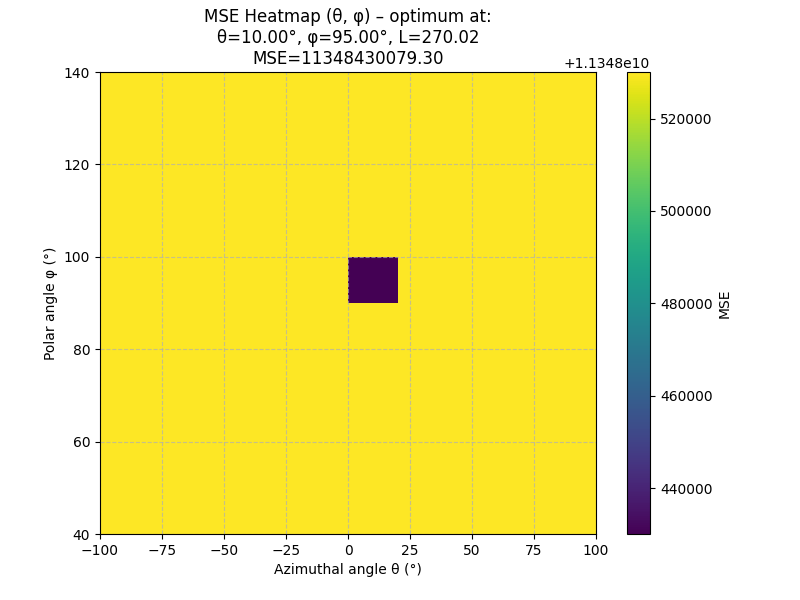

In [110]:
MSP_pipeline(
    base_path =r"/home/loriskeller/Documents/Master Project/Patient data/patient_data_complete/Patient_structures_clean",
    output_path = r"/home/loriskeller/Documents/Master Project/Results/28.07.25",
    structure_names = ["Image", "Body", "GTVp", "Spinal Cord", "Mandible"],
    slice_axis = 2,
    HU_range=[300, 2800],
    slice_range=None,
    azimuthal=(0, 90),
    polar=(90, 45),
    initialization_steps=10,
    widget=True,
    patient = 4927494
)